In [ ]:
from __future__ import annotations
import numpy as np
from operator import itemgetter
import numba as nb
import warnings
from dataclasses import dataclass
from typing import Callable
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial

In [ ]:
#There is a lot of copying arrays and some memory inefficiencies. Most functions should work without modifying the input array. Further optimizations could be made with the compromise of
#there may be some implementation bugs




class FitnessFunction:

    __slots__ = ("f","use_numba","_numbaized","fitness_func")

    def __init__(self, f: Callable, use_numba= True):
        self._numbaized = False
        if use_numba:
            try:
                self.f = nb.njit(f)
                self._numbaized = True
            except:
                self.f = f
                warnings.warn("Function can't be converted with numba! using pure Python")
        else:
            self.f = f

        if self._numbaized:
            self.fitness_func = self.fitness_f_nb
        else:
            self.fitness_func = self.fitness_f

    def __call__(self, population:np.array):
        fitness = self.fitness_func(self.f, population)
        return fitness

    @staticmethod
    @nb.njit
    def fitness_f_nb(f, population:np.array) -> np.array:
        N = population.shape[0]
        M = population.shape[1]
        fitness = np.zeros(N, dtype = float)

        for i in nb.prange(N):
            fitness[i] = f(population[i])
        return fitness

    @staticmethod
    def fitness_f(f, population:np.array) ->np.array:
        return np.apply_along_axis(f, 1, population)


class PopulationSelector:


    def __init__(self, funcs:list[Callable|str], probas:list=None):
        if probas is None:
            probas = np.ones(len(funcs))
        else:
            probas = np.array(probas)
        t = []
        for f in funcs:
            if type(f)==str:
                t.append(getattr(PopulationSelector, f))
            else:
                t.append(f)
        self.funcs = t

        self.probas = probas/probas.sum()

    def __call__(self, fitness:np.array, N):
        f = np.random.choice(self.funcs, p=self.probas)
        return f(fitness, N)

    @staticmethod

    def roulette_selection(fitness:np.array, N:int) ->np.array: #returns N pairs
        probas = fitness/fitness.sum()
        idx = np.arange(fitness.shape[0])
        p = np.random.choice(idx,
                             size = (N,2),
                             p=probas)
        return p
    @staticmethod

    def stochastic_universal_sampling(fitness:np.array, N:int) -> np.array: #This implementation might be wrong, but it's close enough ? gets N pairs
        N=2*N

        probas = fitness/fitness.sum()
        total = probas.sum()
        proportions = (probas*N/total).round().astype(int)
        proportions[-1] = N - (proportions[:-1]).sum()
        idx = np.arange(fitness.shape[0])
        pop = np.repeat(idx, proportions)
        np.random.shuffle(pop)

        return pop.reshape(N//2,2)

    @staticmethod

    def rank_based(fitness:np.array, N:int) -> np.array:
        ranks = np.argsort(fitness )
        probas = ranks/ranks.sum()
        idx = np.arange(fitness.shape[0])
        p = np.random.choice(idx,
                             size = (N,2),
                             p=probas)
        return p

    @staticmethod
    def scaled_selection(fitness:np.array, N:int):
        raise NotImplementedError()

    @staticmethod
    def tournament_selection(fitness:np.array, N:int):
        raise NotImplementedError()






class PopulationOptimizer:
    def __init__(self, population:np.array,
                        fitness_func: Callable|FitnessFunction,
                        selector: Callable|str|PopulationSelector,
                        crossover: Callable|str|PopulationCrossover,
                        mutater: Callable|str|PopulationMutater):
        N = population.shape[0]

        if N%2!=0:
            raise ValueError("Currently only works with an even number of individuals due to optimizations")
        self.population = population
        if type(crossover) == str:
            crossover = getattr(PopulationCrossover, crossover)

        if type(mutater) == str:
            mutater = getattr(PopulationMutater, mutater)
        if type(selector) == str:
            selector = getattr(PopulationSelector, selector)


        self.fitness_func = fitness_func
        self.crossover = crossover
        self.mutater = mutater
        self.metrics = {}


    @staticmethod
    @nb.jit(nopython=False, forceobj=True)
    def optimize(population, fitness_func, selector, crossover, mutater, top_k=5, iters=10, disable=False): # A bigger population size is preferred, can probably optimize the for
                                                                                                                # Create a loop for all numba functions or something
        for i in range(iters):
            dtype = population.dtype
            N = population.shape[0]
            pop_N = population.shape[1]
            fitness = fitness_func(population)

            current_fit = fitness_func(population)
            best_n = population[np.flipud((np.argsort(current_fit)))[:top_k]]

            selected = population[selector(fitness, N//2)]

            cross = crossover(selected).reshape(N, pop_N)

            mutated = mutater(cross)
            population = mutated
            r = np.random.randint(0, N, size=top_k)
            population[r] = best_n


        return population
    @staticmethod
    def optimize_metrics(population, fitness_func, selector, crossover, mutater, iters=10, batches=10,disable=False, disable_inner = True, get_best_n=5, top_k=5):
        metrics = {}
        metrics["best_n"] = []
        metrics["worst_n"] = []
        metrics["mean"] = []
        metrics["best_chromosome"] = []
        metrics["last_population"] = None
        metrics["last_fitness"] = None
        metrics["fits"] = None

        for batch in tqdm(range(batches), disable=disable):
            population = PopulationOptimizer.optimize(population,  fitness_func, selector, crossover, mutater, iters=iters, disable=disable_inner, top_k=top_k)
            current_fit = fitness_func(population)
            b_n = np.flipud(np.argsort(current_fit))
            best_n = current_fit[b_n[:get_best_n]]
            worst_n = current_fit[np.flipud(b_n)[:get_best_n]]










            best_c = population[np.argmax(current_fit)]
            metrics["mean"].append(current_fit.mean())
            metrics["best_n"].append(best_n)
            metrics["worst_n"].append(worst_n)
            metrics["best_chromosome"].append(best_c)
            metrics["last_population"] = population
            metrics["last_fitness"] = current_fit
        return metrics


    @staticmethod
    def optimize_draw(population, fitness_func, selector, crossover, mutater, iters=10, batches=10,disable=False, disable_inner = True, get_best_n=5, top_k=5):
        metrics = PopulationOptimizer.optimize_metrics(population, fitness_func, selector, crossover, mutater, iters=iters,
                                                       batches=batches,disable=False, disable_inner = disable_inner, get_best_n=get_best_n, top_k=top_k)
        plt.title("mean")
        plt.plot(np.arange(len(metrics["mean"])), metrics["mean"])
        plt.show()

        plt.title("best and worst")
        plt.plot(np.arange(len(metrics["best_n"])), [x[0] for x in metrics["best_n"]])
        plt.plot(np.arange(len(metrics["worst_n"])), [x[0] for x in metrics["worst_n"]])
        plt.show()

        plt.title("boxplot last fitness")
        plt.boxplot(metrics["last_fitness"])
        plt.show()

        plt.title("hist last fitness")
        plt.hist(metrics["last_fitness"])
        plt.show()
        return metrics

class PopulationCrossover:

    def __init__(self, funcs:list[Callable|str], probas:list=None):
        if probas is None:
            probas = np.ones(len(funcs))
        else:
            probas = np.array(probas)
        t = []
        for f in funcs:
            if type(f)==str:
                t.append(getattr(PopulationCrossover, f))
            else:
                t.append(f)
        self.funcs = t

        self.probas = probas/probas.sum()

    def __call__(self, population_2d:np.array):
        f = np.random.choice(self.funcs, p=self.probas)
        return f(population_2d)




    @staticmethod
    @nb.njit
    def single_point_crossover(population_2d:np.array): #population_2d is an array with pairs of individuals.
                                                        #Don't really know how to vectorize this. numpy won't allow me to have irregular shaped arrays :(
                                                        #Can probably use a weird shape like a triangle matrix or something or a [0,0,0,1..] mat
                                                        #Can probably create a mask first for the selection
        """population_2d -> numpy array with dims Nx2xlen_chromosome.
                            It contains pairs of individuals to make the crossover"""
        N = population_2d.shape[0]
        pop_N = population_2d.shape[2]
        cutoffs = np.random.randint(0, pop_N, size=N)
        new = np.zeros(population_2d.shape, dtype=population_2d.dtype)
        for i in nb.prange(N):

            new[i] = np.stack((np.concatenate((population_2d[i,0,:cutoffs[i]], population_2d[i,1,cutoffs[i]:]), axis=0),
                                  np.concatenate((population_2d[i,1,:cutoffs[i]], population_2d[i,0,cutoffs[i]:]), axis=0)), axis=0)


        return new

    @staticmethod
    @nb.njit
    def k_point_crossover(population_2d:np.array, k:int=2)->np.array: #Fix this
        N = population_2d.shape[0]
        pop_N = population_2d.shape[2]
        cutoffs = np.random.randint(0, pop_N, size=(N,k)) #should have 2 points so dim (N,2,k)
        new = np.zeros(population_2d.shape, dtype=population_2d.dtype)
        for k in nb.prange(k):
            for i in nb.prange(N):

                new[i] = np.stack((np.concatenate((population_2d[i,0,:cutoffs[i,k]], population_2d[i,1,cutoffs[i,k]:]), axis=0),
                                        np.concatenate((population_2d[i,1,:cutoffs[i,k]], population_2d[i,0,cutoffs[i,k]:]), axis=0)), axis=0)


            return new

    @staticmethod
    @nb.njit
    def uniform_crossover(population_2d:np.array)->np.array: #This could be more efficient, probably, or maybe not
        N = population_2d.shape[0]
        pop_N = population_2d.shape[2]

        idx = np.random.randint(0,2,size=population_2d.shape)
        new = np.zeros(population_2d.shape, dtype=population_2d.dtype)
        new[:,0,:] = np.where(idx[:,0,:], population_2d[:,0,:], population_2d[:,1,:])
        new[:,1,:] = np.where(idx[:,1,:], population_2d[:,0,:], population_2d[:,1,:])
        return new

    @staticmethod
    @nb.njit
    def blend_crossover(population_2d:np.array)->np.array:#Probably slow

        pop_N = population_2d.shape[2]

        new = population_2d.copy()
        for i in range(new.shape[0]):

            vals0 = np.zeros(pop_N)
            vals1 = np.zeros(pop_N)
            for k in range(pop_N): #Could be faster....

                new[i,0,k] += np.random.uniform(population_2d[i,0,k]-0.5*(population_2d[i,1,k]- population_2d[i,0,k]),
                                            population_2d[i,1,k]+0.5*(population_2d[i,1,k]- population_2d[i,0,k])) #x1-a(x2-x1), x2+a(x2-x1)
                new[i,1,k] += np.random.uniform(population_2d[i,0,k]-0.5*(population_2d[i,1,k]- population_2d[i,0,k]),
                                            population_2d[i,1,k]+0.5*(population_2d[i,1,k]- population_2d[i,0,k]))
        return new

    @staticmethod
    def real_mutation(population_2d:np.array)->np.array:
        raise NotImplementedError
    @staticmethod
    def ordered_crossover(population_2d:np.array)->np.array:
        raise NotImplementedError()
class PopulationMutater:

    def __init__(self, funcs: list[str|Callable], probas = None):
        t = []
        for f in funcs:
            if type(f)==str:
                t.append(getattr(PopulationMutater, f))
            else:
                t.append(f)
        self.funcs = t
        self.probas = probas

    def __call__(self, population):
        N = population.shape[0]
        pop_N = population.shape[1]
        for i,f in enumerate(self.funcs):

            temp = f(population)
            if self.probas:
                mask = np.tile(np.random.uniform(0,1, N )<self.probas[i], (pop_N,1)).T


                temp = np.where(mask, temp, population)

            population = temp
        return population


    @staticmethod
    @nb.njit
    def flip_all_bit(population:np.array)->np.array:
        return np.invert(population.copy()) #bitwise not


    @staticmethod

    def flip_bit(population:np.array)->np.array:
        N = population.shape[0]
        pop_N = population.shape[1]
        new = population.copy()
        r = np.random.randint(0, pop_N, size=N)

        first = np.arange(N)
        new[first,r] = np.invert(new[first,r])
        return new


    @staticmethod

    def swap_mutation(population:np.array)->np.array:
        N = population.shape[0]
        pop_N = population.shape[1]
        swaps = np.random.randint(0, pop_N, size=(N,2))

        new = population.copy()
        first = np.arange(N)

        new[first,swaps[:,1]] = new[first,swaps[:,0]] # for some reason new[:,swaps[:,0]] doesn't work as expected, also can't do this with numba on .-.

        new[first,swaps[:,0]] = population[first,swaps[:,1]].copy()

        return new

    @staticmethod
    @nb.njit
    def inversion_mutation(population:np.array)->np.array: # Numpy wont let me create irregular arrays again :(. Could try to do something smart like using a mask to select between the original
                                                            # and an inverted version of the population, but at that point I don't know how much, if any, more efficient it would be. Probably nothing
        N = population.shape[0]
        pop_N = population.shape[1]
        inversions = np.random.randint(0, pop_N, size=(N,2))
        first = np.arange(N)
        new = population.copy()
        for i in range(N):
            s1 = inversions[i,0]
            s2 = inversions[i,1]

            if s1>s2:
                s1, s2 = s2, s1

            new[i, s1:s2 ] = np.flip(population[i, s1:s2])

        return new


    @staticmethod
    @nb.njit
    def scramble_mutation(population:np.array)->np.array:
        N = population.shape[0]
        pop_N = population.shape[1]
        inversions = np.random.randint(0, pop_N, size=(N,2))
        first = np.arange(N)
        new = population.copy()
        for i in range(N):
            s1 = inversions[i,0]
            s2 = inversions[i,1]
            if s1>s2:
                s1, s2 = s2, s1

            new[i, s1:s2 ] = np.random.permutation(population[i, s1:s2])

        return new

    @staticmethod

    def non_uniform_mutation(population:np.array)->np.array:
        pop_N = population.shape[1]
        N = population.shape[0]
        new = population.copy()
        var = np.random.randint(-1,2, pop_N)*(np.max(new, axis=0)-np.min(new,axis=0))*(1-np.power(np.random.uniform(0,1), (1-np.random.uniform(0,1)**2)))
                                            # x + t(x_max - x_min)*(1-r**((1-t/t_max)**b)) https://engineering.purdue.edu/~sudhoff/ee630/Lecture04.pdf
        new +=var
        return new

    def normal_mutation(population:np.array, dev=1)->np.array:
        new = population.copy()
        new += np.random.normal(0,dev, size = population.shape)
        return new

def sigmoid(x):
    return 1/(1+np.e**(-x))

def relu(x):
    return np.maximum(x, 0)

def nn_forward(params, X, layer_sizes, activations, bias=False): #If using a bias, it will collect layer_size[i] from params, changing number of params. first layer is input layer
                                                                # If bias=False, the total number of params is sum((l[i]*l[i+1]), i=len(layer_sizes)-1
                                                                # If bias=True, the size will be sum(l[i]*l[i+1]+l[i+1])
    if bias:
        ws = []
        bs = []
        prev = 0
        for i in range(len(layer_sizes)-1):
            bias_length = layer_sizes[i+1]
            bs.append(params[prev:prev+bias_length])
            prev+=bias_length
            length = layer_sizes[i]*layer_sizes[i+1]

            ws.append(params[prev:prev+length].copy().reshape(layer_sizes[i+1], layer_sizes[i]))
            prev += length

        current = X

        for i in range(len(layer_sizes)-1):

            Z = np.dot(ws[i], current)+bs[i].reshape(bs[i].shape[0],1)

            A = activations[i](Z)

            current = A
    else:
        ws = []
        prev = 0
        for i in range(len(layer_sizes)-1):
            length = layer_sizes[i]*layer_sizes[i+1]
            ws.append(params[prev:prev+length].copy().reshape(layer_sizes[i+1], layer_sizes[i]))
            prev += length


        current = X
        for i in range(len(layer_sizes)-1):

            Z = np.dot(ws[i], current)
            A = activations[i](Z)
            current = A
    return current

def binary_cross_entropy(y_hat,y, epsilon=1e-10):
    N = y.shape[0]
    return -(1/N)*(y*np.log(y_hat+epsilon)+(1-y)*np.log(1-y_hat+epsilon)).sum()

def nn_fitness(population, X, y, layer_sizes, activations, bias=True):
    #print(population)
    fitness = np.zeros(population.shape[0] )
    for i in range(population.shape[0]):

        fitness[i] = binary_cross_entropy(nn_forward(population[i], X, layer_sizes, activations, bias), y)
    return 100-fitness #fix this please




#fitness = FitnessFunction(lambda x: np.random.randint(0,100), use_numba=True)
X = np.array([[0,0],
              [1,0],
              [0,1],
              [1,1]]).T
y = np.array([0,1,1,0])
fitness = partial(nn_fitness, X=X, y=y, layer_sizes=[2,1], activations=[sigmoid] )
selector = PopulationSelector(["rank_based"])
crossover = PopulationCrossover(["blend_crossover", "single_point_crossover"], probas=[0.5, 0.5])
mutater = PopulationMutater([ "non_uniform_mutation", 'normal_mutation'], probas=[0.1,0.1])
darr = np.random.randint(0,2, size=(8,4))
optimizer = PopulationOptimizer(darr, fitness, selector, crossover, mutater)
#TODO stop flag, environment, move to library.........................h

In [ ]:
binary_cross_entropy(np.array([0,1,1,0]), y)

-1.000000082690371e-10

In [ ]:

weights = np.random.uniform(0,1, (100, 14+2+3+2))
#weights = np.random.uniform(0,1,14+2+3+2)
#nn_forward(weights, X, [2,3,2,1], [sigmoid, sigmoid, sigmoid], bias=True)


In [ ]:
fitness(weights)

array([99.1521777 , 99.13053015, 99.26675573, 99.29709008, 99.14186526,
       99.24184523, 99.26529954, 99.09650517, 99.21974101, 99.10714518,
       99.20031619, 99.11344659, 99.27155483, 99.24499355, 99.12577622,
       99.24342799, 99.09267798, 99.12066208, 99.13873706, 99.07661405,
       99.18824497, 99.19680864, 99.16320404, 99.25542767, 99.11684625,
       99.10256064, 99.29752305, 99.15696489, 99.2664841 , 99.24305651,
       99.12581963, 99.22258985, 99.15982505, 99.0272793 , 99.18307894,
       99.19514332, 99.20373896, 99.19187633, 99.06598847, 99.04107214,
       99.00406075, 99.13432809, 99.2569973 , 99.12085281, 99.18796184,
       99.20892077, 99.28001188, 99.17740217, 99.14277005, 99.16806166,
       99.09989909, 99.15449479, 99.29214093, 99.20530641, 99.16451141,
       99.21859586, 99.1671921 , 99.17001044, 99.18336315, 99.08611392,
       99.12574826, 99.17517653, 99.02334071, 99.1430402 , 99.15904354,
       99.2074857 , 99.14068342, 99.26567203, 99.12468581, 99.13

 10%|█         | 1/10 [00:02<00:26,  2.93s/it]<ipython-input-15-4dfd303a5c92>:449: RuntimeWarning: overflow encountered in power
  return 1/(1+np.e**(-x))
100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


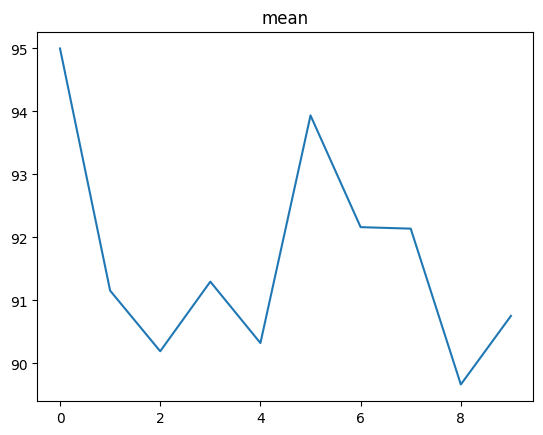

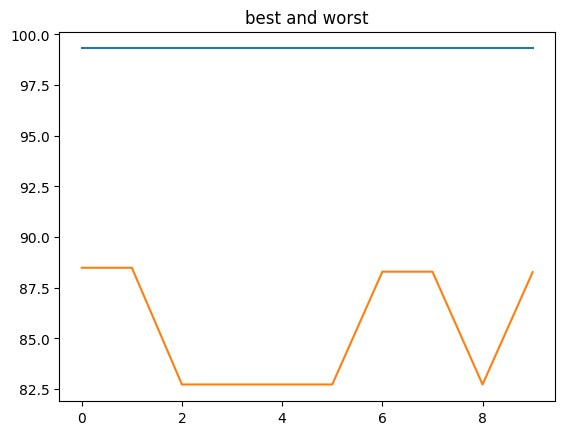

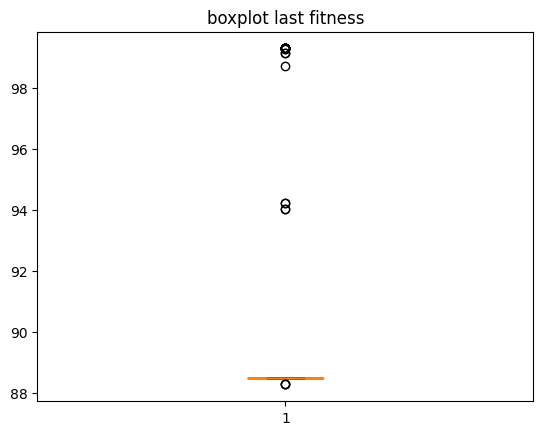

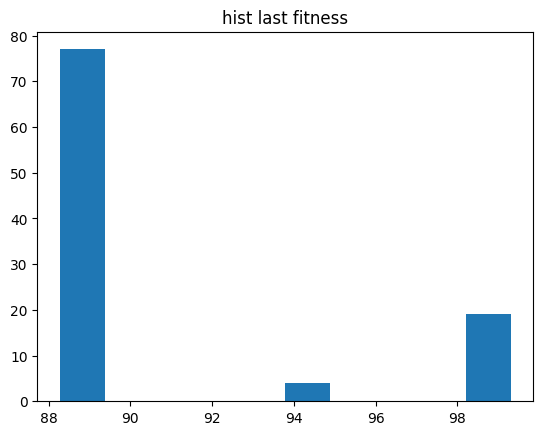

In [ ]:
#arr = np.random.randint(0,2, size=(1000,100))
pop = optimizer.optimize_draw(weights, fitness, selector, crossover, mutater, iters=10, batches=10,  top_k=10)

In [ ]:
pop["best_chromosome"][-1]

array([ 1.44122975e-01,  3.35183163e-02, -1.22390179e-01,  1.39514447e+11,
       -4.50504985e+08,  4.40427177e+11,  5.54185921e+09,  1.36515338e+11,
       -1.76583882e+11,  5.07077720e+11, -2.54136737e+10,  4.07640723e+10,
        9.56286691e+10, -1.54005527e+11, -1.88560174e+11, -3.21596398e+10,
       -2.96763643e+10, -6.29035505e+11, -3.05711180e+11, -8.91180849e+10,
        3.60747838e+08])

In [ ]:

nn_forward(pop["best_chromosome"][-1], X, [2,3,2,1], [relu, sigmoid, sigmoid], bias=True)

<ipython-input-2-11242b3fab45>:439: RuntimeWarning: overflow encountered in power
  return 1/(1+np.e**(-x))


array([[1.78897353e-23, 1.00000000e+00, 1.00000000e+00, 1.78897353e-23]])

In [ ]:
X = np.array([[3, 100, 400, 1, 0, 3],
              [1, 40, 530, 2, 5, 2]])
y = np.array([0, 1, 1, 0, 0 ,0 ])
fitness = partial(nn_fitness, X=X, y=y, layer_sizes=[2,3,2, 1], activations=[relu,sigmoid, sigmoid] )
selector = PopulationSelector(["rank_based"])
crossover = PopulationCrossover(["blend_crossover", "single_point_crossover"], probas=[0.5, 0.5])
mutater = PopulationMutater([ "non_uniform_mutation", 'normal_mutation'], probas=[0.1,0.1])
darr = np.random.randint(0,2, size=(8,4))
optimizer = PopulationOptimizer(darr, fitness, selector, crossover, mutater)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-2-11242b3fab45>:439: RuntimeWarning: overflow encountered in power
  return 1/(1+np.e**(-x))
100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


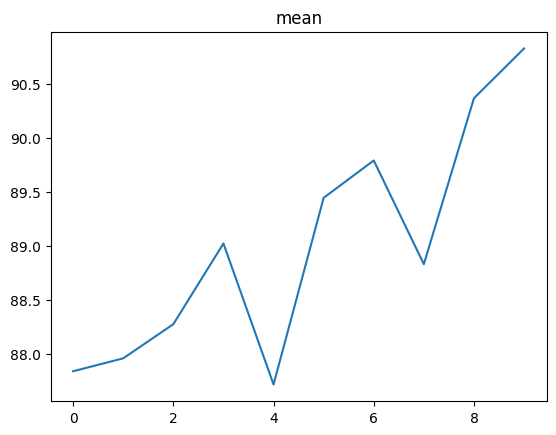

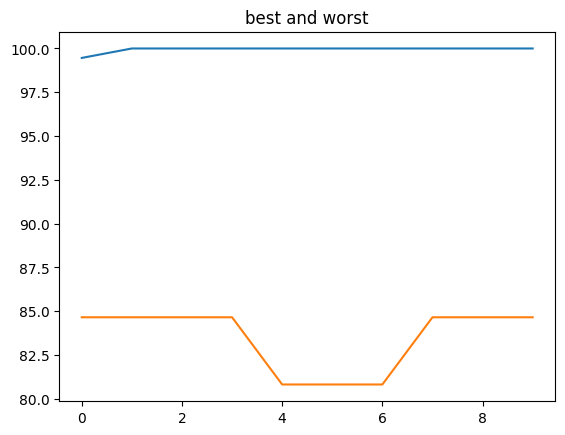

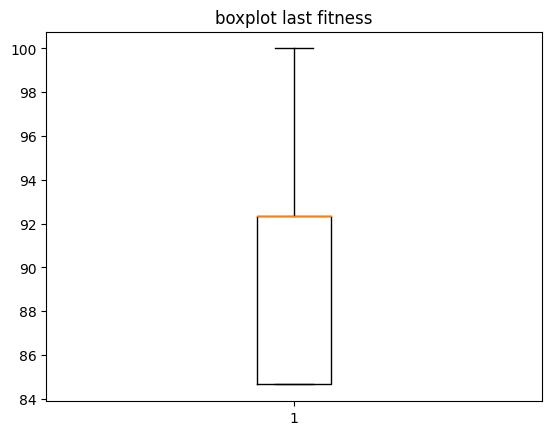

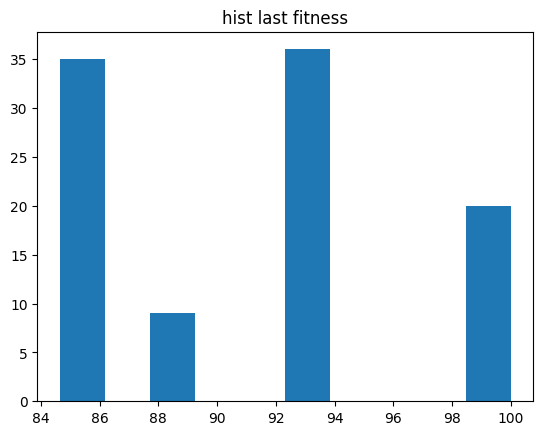

In [ ]:
pop = optimizer.optimize_draw(weights, fitness, selector, crossover, mutater, iters=10, batches=10,  top_k=10)

In [ ]:
X_test = np.array([[1,500, 233, 1],
                   [0,502, 233, 2]])
nn_forward(pop["best_chromosome"][-1], X_test, [2,3,2,1], [relu, sigmoid, sigmoid], bias=True)

<ipython-input-2-11242b3fab45>:439: RuntimeWarning: overflow encountered in power
  return 1/(1+np.e**(-x))


array([[0., 1., 1., 0.]])

In [ ]:
X = np.array([[-5, 5, -2, 6, -4, -3, -7],
              [5, 2, -7, 4 ,-6, 4, 5]])
y = np.array([0, 1, 1, 1, 1, 0 ,0 ])
fitness = partial(nn_fitness, X=X, y=y, layer_sizes=[2,3,2, 1], activations=[relu,sigmoid, sigmoid] )
selector = PopulationSelector(["rank_based"])
crossover = PopulationCrossover(["blend_crossover", "single_point_crossover"], probas=[0.5, 0.5])
mutater = PopulationMutater([ "non_uniform_mutation", 'normal_mutation'], probas=[0.1,0.1])
darr = np.random.randint(0,2, size=(8,4))
optimizer = PopulationOptimizer(darr, fitness, selector, crossover, mutater)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-328-5ea1c3fbf4b1>:439: RuntimeWarning: overflow encountered in power
  return 1/(1+np.e**(-x))
100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


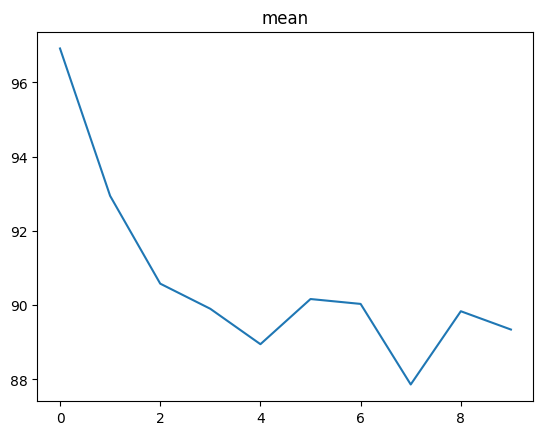

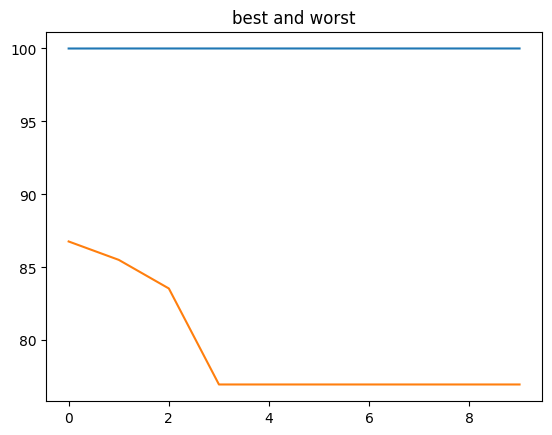

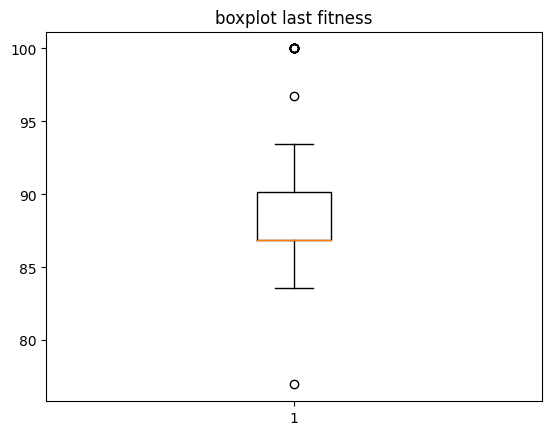

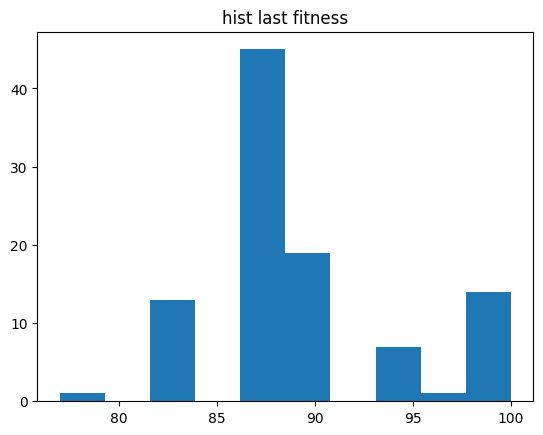

In [ ]:
pop = optimizer.optimize_draw(weights, fitness, selector, crossover, mutater, iters=10, batches=10,  top_k=10)

In [ ]:
X_test = np.array([[-1,500, -233, 1],
                   [5,502, 233, 2]])
nn_forward(pop["best_chromosome"][-1], X_test, [2,3,2,1], [relu, sigmoid, sigmoid], bias=True)

<ipython-input-328-5ea1c3fbf4b1>:439: RuntimeWarning: overflow encountered in power
  return 1/(1+np.e**(-x))


array([[0., 1., 0., 1.]])